# Verkehrszeichenerkennung in Dashcam-Videos
Dieses Notebook lädt ein Eingangs-Video, erkennt Verkehrszeichen mit einem vortrainierten YOLOv5-Modell und erstellt ein Ausgangsvideo mit eingeblendeten Schildernamen.

## Schritte:
1. Imports und Setup
2. Video laden
3. Modell laden
4. Erkennung und Untertitelung
5. Ausgabevideo speichern


#import os
#os.system("pip freeze | xargs pip uninstall -y")

In [ ]:
%pip install -r requirements_notebook.txt

In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt
import warnings
from IPython.display import display

%matplotlib inline

warnings.filterwarnings("ignore", category=FutureWarning)

print(torch.__version__)

torch.cuda.is_available()

In [ ]:
import yaml

with open('../yolo_training/yolo_training.yaml', 'r') as f:
    data = yaml.safe_load(f)

class_names = data['names']
print(f"{len(class_names)} Klassen geladen:")
print(class_names)

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='best.pt', force_reload=True)

In [9]:
video_path = 'input_videos/gute_sicht_1080p.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Fehler: Video konnte nicht geöffnet werden.")
else:
    print("Video erfolgreich geöffnet.")

ret, frame = cap.read()
if not ret:
    print("Kein Frame gelesen.")
else:
    print("Frame gelesen:", frame.shape)

fps = cap.get(cv2.CAP_PROP_FPS)
print("Video-FPS:", fps)


Video erfolgreich geöffnet.
Frame gelesen: (1080, 1920, 3)
Video-FPS: 29.97002997002997


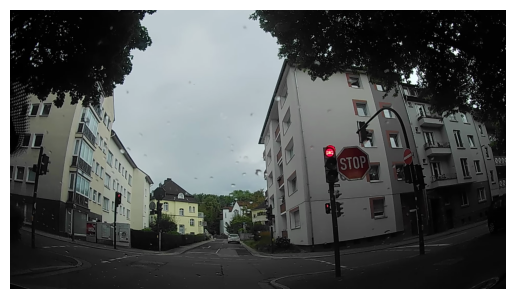

In [10]:
img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots()
ax.imshow(img_rgb)
ax.axis('off')
display(fig)
plt.close(fig)

In [ ]:
# 1080p in Kacheln aufteilen

# Schwellenwerte
CONF_THRESHOLD = 0.3
MAX_BOX_AREA_RATIO = 0.08
MAX_FRAMES = 999999
FRAME_START = 0

# Frame-Parameter
FRAME_H = 720
FRAME_W = 1280

# Rescaling der Frames, so dass es zum Modell passt
TARGET_W = 640
TARGET_H = 360
SCALE = 2
PADDING_V = 140
PADDING_H = 0

# Modellparameter
MODEL_INPUT_SIZE = 640

# Abgeleitete Werte
MAX_BOX_AREA = MAX_BOX_AREA_RATIO * FRAME_W * FRAME_H

# Initialisierung
frame_count = FRAME_START

cap.release()
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)

output_path = 'output_videos/ergebnis_640.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_frame_size = (MODEL_INPUT_SIZE, MODEL_INPUT_SIZE)
writer = cv2.VideoWriter(output_path, fourcc, fps, output_frame_size)
print("VideoWriter initialisiert.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(frame_rgb, (TARGET_W, TARGET_H))
    img_resized = cv2.copyMakeBorder(resized, PADDING_V, PADDING_V, PADDING_H, PADDING_H, cv2.BORDER_CONSTANT, value=(114, 114, 114))

    input_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0

    with torch.no_grad():
        preds = model(input_tensor)[0].cpu().tolist()

    for pred in preds:
        # print(f"pred: {pred}")
        cx, cy, w, h = pred[0], pred[1], pred[2], pred[3]
        objectness = pred[4]
        class_scores = pred[5:]

        max_score = max(class_scores)
        conf = objectness * max_score
        if conf < CONF_THRESHOLD:
            continue

        cls_index = class_scores.index(max_score)
        print(f"conf={conf:.4f} für Klasse {cls_index}")

        x1 = int(cx - w / 2)
        y1 = int(cy - h / 2)
        x2 = int(cx + w / 2)
        y2 = int(cy + h / 2)

        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(MODEL_INPUT_SIZE, x2)
        y2 = min(MODEL_INPUT_SIZE, y2)

        print(f"Rechteck: {x1},{y1} -> {x2},{y2}")
        box_area = (x2 - x1) * (y2 - y1)

        label = class_names[cls_index]
        cv2.rectangle(img_resized, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_resized, label, (10, MODEL_INPUT_SIZE - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        print(f"Gezeichnet: {label}")

    writer.write(cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))

    frame_count += 1
    if frame_count % 100 == 0:
        print(f"{frame_count} Frames verarbeitet.")

    if frame_count >= MAX_FRAMES:
        print(f"Es wurden {MAX_FRAMES} Frames verarbeitet und die Verarbeitung wird beendet.")
        break     

cap.release()
writer.release()
print("Fertig.")


In [ ]:
# OUTPUT-VIDEO 640 x 640

# Schwellenwerte
CONF_THRESHOLD = 0.3
MAX_BOX_AREA_RATIO = 0.08
MAX_FRAMES = 999999
FRAME_START = 0

# Frame-Parameter
FRAME_H = 720
FRAME_W = 1280

# Rescaling der Frames, so dass es zum Modell passt
TARGET_W = 640
TARGET_H = 360
SCALE = 2
PADDING_V = 140
PADDING_H = 0

# Modellparameter
MODEL_INPUT_SIZE = 640

# Abgeleitete Werte
MAX_BOX_AREA = MAX_BOX_AREA_RATIO * FRAME_W * FRAME_H

# Initialisierung
frame_count = FRAME_START

cap.release()
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)

output_path = 'output_videos/ergebnis_640.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_frame_size = (MODEL_INPUT_SIZE, MODEL_INPUT_SIZE)
writer = cv2.VideoWriter(output_path, fourcc, fps, output_frame_size)
print("VideoWriter initialisiert.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(frame_rgb, (TARGET_W, TARGET_H))
    img_resized = cv2.copyMakeBorder(resized, PADDING_V, PADDING_V, PADDING_H, PADDING_H, cv2.BORDER_CONSTANT, value=(114, 114, 114))

    input_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0

    with torch.no_grad():
        preds = model(input_tensor)[0].cpu().tolist()

    for pred in preds:
        # print(f"pred: {pred}")
        cx, cy, w, h = pred[0], pred[1], pred[2], pred[3]
        objectness = pred[4]
        class_scores = pred[5:]

        max_score = max(class_scores)
        conf = objectness * max_score
        if conf < CONF_THRESHOLD:
            continue

        cls_index = class_scores.index(max_score)
        print(f"conf={conf:.4f} für Klasse {cls_index}")

        x1 = int(cx - w / 2)
        y1 = int(cy - h / 2)
        x2 = int(cx + w / 2)
        y2 = int(cy + h / 2)

        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(MODEL_INPUT_SIZE, x2)
        y2 = min(MODEL_INPUT_SIZE, y2)

        print(f"Rechteck: {x1},{y1} -> {x2},{y2}")
        box_area = (x2 - x1) * (y2 - y1)

        label = class_names[cls_index]
        cv2.rectangle(img_resized, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_resized, label, (10, MODEL_INPUT_SIZE - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        print(f"Gezeichnet: {label}")

    writer.write(cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))

    frame_count += 1
    if frame_count % 100 == 0:
        print(f"{frame_count} Frames verarbeitet.")

    if frame_count >= MAX_FRAMES:
        print(f"Es wurden {MAX_FRAMES} Frames verarbeitet und die Verarbeitung wird beendet.")
        break     

cap.release()
writer.release()
print("Fertig.")


In [ ]:
# OUTPUT-VIDEO 1280 x 720

# Schwellenwerte
CONF_THRESHOLD = 0.6
MAX_BOX_AREA_RATIO = 0.08
MAX_FRAMES = 100
FRAME_START = 0

# Frame-Parameter
FRAME_H = 720
FRAME_W = 1280

# Rescaling der Frames, so dass es zum Modell passt
TARGET_W = 640
TARGET_H = 360
SCALE = 2
PADDING_V = 140
PADDING_H = 0

# Modellparameter
MODEL_INPUT_SIZE = 640

# Abgeleitete Werte
MAX_BOX_AREA = MAX_BOX_AREA_RATIO * FRAME_W * FRAME_H

# Initialisierung
frame_count = FRAME_START

cap.release()
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)

output_path = 'output_videos/ergebnis.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_frame_size = (FRAME_W, FRAME_H)

writer = cv2.VideoWriter(output_path, fourcc, fps, output_frame_size)
print("VideoWriter initialisiert.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(frame_rgb, (TARGET_W, TARGET_H))
    img_resized = cv2.copyMakeBorder(resized, PADDING_V, PADDING_V, PADDING_H, PADDING_H, cv2.BORDER_CONSTANT, value=(114, 114, 114))

    input_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0

    with torch.no_grad():
        preds = model(input_tensor)[0].cpu().tolist()

    for pred in preds:
        # print(f"pred: {pred}")
        cx, cy, w, h = pred[0], pred[1], pred[2], pred[3]
        objectness = pred[4]
        class_scores = pred[5:]

        max_score = max(class_scores)
        conf = objectness * max_score
        if conf < CONF_THRESHOLD:
            continue

        cls_index = class_scores.index(max_score)
        print(f"conf={conf:.4f} für Klasse {cls_index}")

        x1 = cx - w / 2
        y1 = cy - h / 2
        x2 = cx + w / 2
        y2 = cy + h / 2

        draw_x1 = int(x1 * SCALE)
        draw_y1 = int((y1 - PADDING_V) * SCALE)
        draw_x2 = int(x2 * SCALE)
        draw_y2 = int((y2 - PADDING_V) * SCALE)

        draw_x1 = max(0, draw_x1)
        draw_y1 = max(0, draw_y1)
        draw_x2 = min(FRAME_W, draw_x2)
        draw_y2 = min(FRAME_H, draw_y2)
        print(f"Rechteck: {draw_x1},{draw_y1} -> {draw_x2},{draw_y2}")

        box_area = (draw_x2 - draw_x1) * (draw_y2 - draw_y1)
        #if box_area > MAX_BOX_AREA:
        #    print(f"Übersprungen wegen Größe: {box_area}px")
        #    continue

        label = class_names[cls_index]
        cv2.rectangle(frame, (draw_x1, draw_y1), (draw_x2, draw_y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        print(f"Gezeichnet: {label}")

    writer.write(frame)

    frame_count += 1
    if frame_count % 100 == 0:
        print(f"{frame_count} Frames verarbeitet.")

    if frame_count >= MAX_FRAMES:
        print(f"Es wurden {MAX_FRAMES} Frames verarbeitet und die Verarbeitung wird beendet.")
        break     

cap.release()
writer.release()
print("Fertig.")
